In [1]:
%load_ext autoreload
%autoreload 2

# Simple representation space tests with an FCN


## Imports


In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from typing import List
from functools import partial

import os
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int  # https://github.com/google/jaxtyping

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score  
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

[gpu(id=0), gpu(id=1)]

In [3]:
from src.models.mlp import MLP, MLP_fn
from src.losses.losses import loss_fn, compute_accuracy_categorical, compute_accuracy_regression

In [4]:
# Make sure GPU is actually working
jnp.arange(9)

Array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

## Load data


In [5]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

## Hyperparameters


In [6]:
BATCH_SIZE = 128
N_BATCHES = 1000
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
train_split_perc = 0.8
TRAIN_SPLIT = int(train_split_perc * TOTAL_DS)
TEST_SPLIT = TOTAL_DS - TRAIN_SPLIT
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 1000
PRINT_EVERY = EPOCHS // 30
SEED = 1
INPUT_SPECIES = 'RNA_1'
target_circ_func = 'sensitivity'
input_concat_diffs = True
input_concat_axis = 0
output_options = ['std', 'ratio', 'log_ratio', 'abs_1_log_ratio']
output_option = output_options[-1]

# MLP Architecture
LAYER_SIZES = [64, 64, 64]
USE_CATEGORICAL = False
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = False

loss_fn = partial(
    loss_fn, loss_type='categorical' if USE_CATEGORICAL else 'mse', use_l2_reg=USE_L2_REG)
compute_accuracy = compute_accuracy_categorical if USE_CATEGORICAL else compute_accuracy_regression

subtask = 'dual_' + output_option + '_' + str(input_concat_diffs) + str(input_concat_axis) + '_'
save_path = 'saves_' + subtask + str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_')

rng = jax.random.PRNGKey(SEED)

## Initialise


### Input

To make sure that there is little repetition in the dataset, the uniqueness of each sample will be judged. For genetic circuits,there is a lot of sparsity, as most biological sequences do not interact. Therefore, there may be an overrepresentation of some circuit topologies.


In [7]:
def custom_round(x, base=5):
    return base * round(x/base)


def convert_to_scientific_exponent(x, numerical_resolution: dict):
    exp_not = f'{x:.0e}'.split('e')
    resolution = numerical_resolution[int(exp_not[1])]
    base = int(10 / resolution)
    pre = custom_round(int(exp_not[0]), base=base)
    return int(exp_not[1]) + pre / 10


def drop_duplicates_keep_first_n(df, column, n):
    """ GCG """
    indices = df[df.duplicated(subset=column, keep=False)].groupby(
        column).head(n).index
    all_duplicates_indices = df[df.duplicated(subset=column, keep=False)].index
    to_drop = list(set(all_duplicates_indices) - set(indices))
    df2 = df.drop(to_drop)
    return df2


vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
filt = data['sample_name'] == INPUT_SPECIES
numerical_resolution = 2


# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=200)
k = 'energies'
df[[f'{i}_diffs' for i in get_true_interaction_cols(data, k, remove_symmetrical=True)]] = df.groupby(
    ['circuit_name'])[get_true_interaction_cols(data, k, remove_symmetrical=True)].apply(lambda x: x - x.iloc[0]).to_numpy()


['std', 'ratio', 'log_ratio', 'abs_1_log_ratio']
dual_suffix = ''
if output_option == 'std':
    dual_suffix = '_std'
    grouped_std = df.groupby(by=['circuit_name', 'mutation_num'])[
        target_circ_func].std().reset_index()
    df = pd.merge(df, grouped_std, on=[
                  'circuit_name', 'mutation_num'], suffixes=('', dual_suffix))
elif output_option == 'ratio':
    dual_suffix = '_ratio_from_mutation_to_base'
elif output_option == 'log_ratio':
    dual_suffix = '_log_ratio'
    df[target_circ_func + dual_suffix] = np.where(df[target_circ_func + '_ratio_from_mutation_to_base']
                                                  == 0, -10, np.log10(df[target_circ_func + '_ratio_from_mutation_to_base']))
elif output_option == 'abs_1_log_ratio':
    dual_suffix = '_abs_log_ratio'
    df[target_circ_func + dual_suffix] = np.abs(np.log10(df[target_circ_func + '_ratio_from_mutation_to_base']))

df[target_circ_func] = df[target_circ_func].round(
    np.abs(int(f'{df[target_circ_func].min():.0e}'.split('e')[1]))-1)
df[target_circ_func + dual_suffix] = df[target_circ_func + dual_suffix].round(
    np.abs(int(f'{df[target_circ_func + dual_suffix].min():.0e}'.split('e')[1]))-1)
df = drop_duplicates_keep_first_n(
    df, column=target_circ_func, n=200)


TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])

/tmp/ipykernel_3348146/3537013222.py:33: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[[f'{i}_diffs' for i in get_true_interaction_cols(data, k, remove_symmetrical=True)]] = df.groupby(


In [8]:
TOTAL_DS

117083

In [9]:
x_cols = [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]
if input_concat_diffs:
    x_cols = x_cols + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, k, remove_symmetrical=True)]]

x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x = np.concatenate(x, axis=input_concat_axis+1)

y_cols = [target_circ_func,
          target_circ_func + dual_suffix]
y = df[y_cols].iloc[:TOTAL_DS].to_numpy()


if USE_CATEGORICAL:
    y_map = {k: numerical_resolution for k in np.arange(int(f'{y[y != 0].min():.0e}'.split(
        'e')[1])-1, np.max([int(f'{y.max():.0e}'.split('e')[1])+1, 0 + 1]))}
    y_map[-6] = 1
    y_map[-5] = 1
    y_map[-4] = 4
    y_map[-3] = 2
    y_map[-1] = 3
    y = jax.tree_util.tree_map(partial(
        vectorized_convert_to_scientific_exponent, numerical_resolution=y_map), y)
    y = np.interp(y, sorted(np.unique(y)), np.arange(
        len(sorted(np.unique(y))))).astype(int)
else:
    zero_log_replacement = -10.0
    y = np.where(y != 0, np.log10(y), zero_log_replacement)

# Make sure there are no nans
x = x[np.sum(np.isnan(y), axis=1) == 0]
y = y[np.sum(np.isnan(y), axis=1) == 0]

x, y = shuffle(x, y, random_state=SEED)

N_HEAD = len(np.unique(y)) if USE_CATEGORICAL else len(y_cols)


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

/tmp/ipykernel_3348146/1314598869.py:29: RuntimeWarning: divide by zero encountered in log10
  y = np.where(y != 0, np.log10(y), zero_log_replacement)


#### Scale input


In [10]:
xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
og_x_shape = x.shape
x = xscaler.fit_transform(x.reshape(og_x_shape[0], np.prod(og_x_shape[1:]))).reshape(og_x_shape).squeeze()
# y = yscaler.fit_transform(y)
# inverse = xscaler.inverse_transform(normalized)

# xscaler, yscaler = StandardScaler(), StandardScaler()
# x = xscaler.fit_transform(x)
# y = yscaler.fit_transform(y)
# inverse = scaler.inverse_transform(standardized)

In [11]:
x.shape

(117083, 12)

In [12]:
x_train, y_train = x[:TRAIN_SPLIT], y[:TRAIN_SPLIT]
x_val, y_val = x[-TEST_SPLIT:], y[-TEST_SPLIT:]

Text(0.5, 1.0, 'y 1: Sensitivity with respect to species-6 abs log ratio')

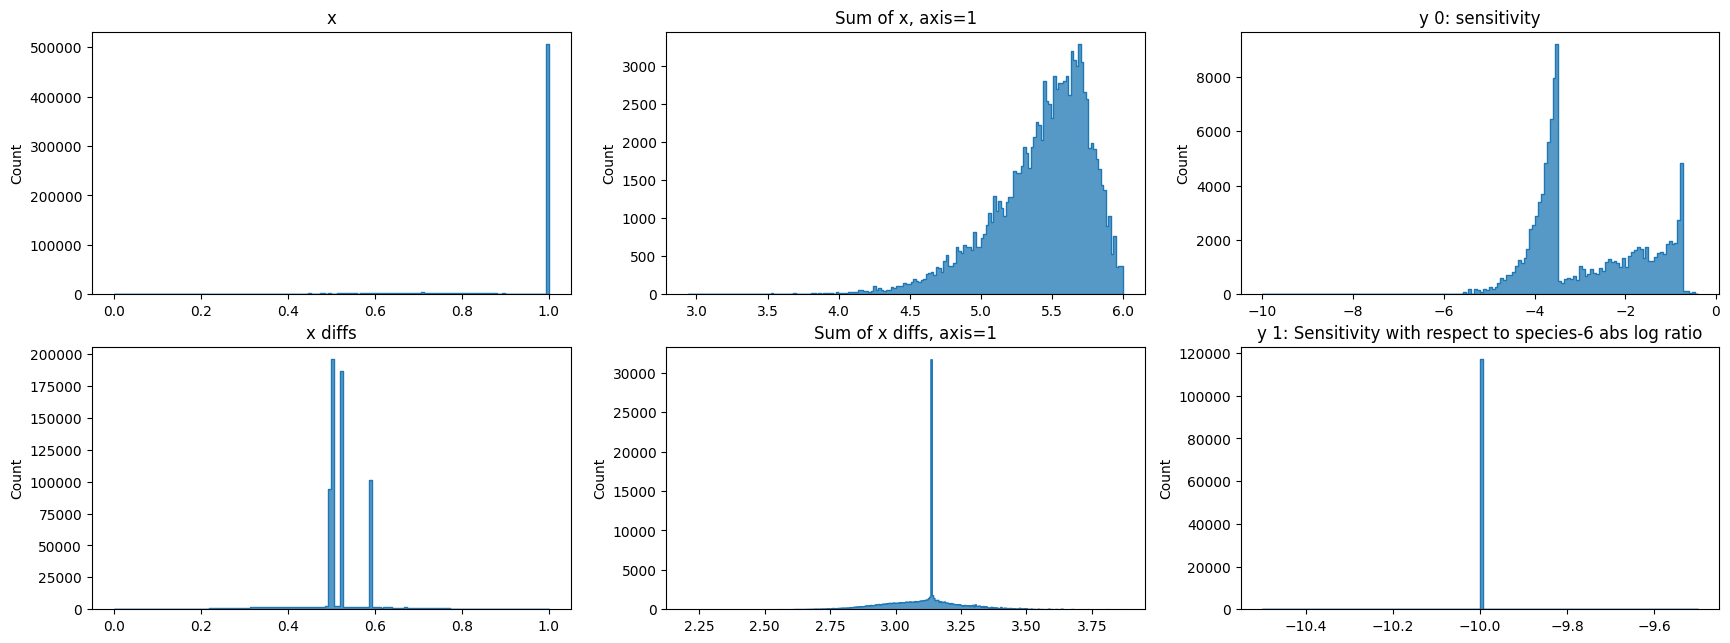

In [13]:
plt.figure(figsize=(3*7, 5 * 1.5))
ax = plt.subplot(2, 3, 1)
sns.histplot(x=x[:, :6].flatten(), element='step', bins=150)
plt.title('x')
ax = plt.subplot(2, 3, 2)
sns.histplot(x=np.sum(x[:, :6], axis=1).flatten(), element='step')
plt.title('Sum of x, axis=1')
ax = plt.subplot(2, 3, 3)
sns.histplot(x=(y[:, 0].flatten()), element='step', bins=150)
plt.title('y 0: sensitivity')

ax = plt.subplot(2, 3, 4)
sns.histplot(x=x[:, 6:].flatten(), element='step', bins=150, log_scale=[False, False])
plt.title('x diffs')
ax = plt.subplot(2, 3, 5)
sns.histplot(x=np.sum(x[:, 6:], axis=1).flatten(), element='step', log_scale=[False, False])
plt.title('Sum of x diffs, axis=1')
ax = plt.subplot(2, 3, 6)
sns.histplot(x=(y[:, 1].flatten()), element='step', bins=150, log_scale=[False, False])
plt.title(f'y 1: {prettify_keys_for_label(target_circ_func + dual_suffix)}') 

Text(0.5, 1.0, 'y')

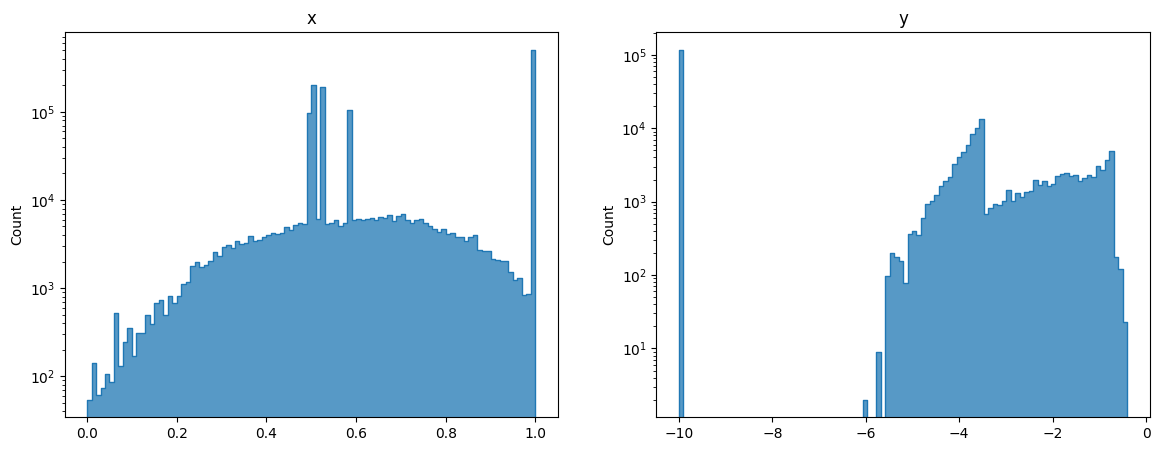

In [14]:
plt.figure(figsize=(2*7, 5))
ax = plt.subplot(1, 2, 1)
sns.histplot(x=x.flatten(), element='step', log_scale=[False, True], bins=100)
plt.title('x')
ax = plt.subplot(1, 2, 2)
sns.histplot(x=y.flatten(), element='step', log_scale=[False, True], bins=100)
plt.title('y')

### Initialise WandB 


In [15]:

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="mlp-encoder_decoder",
#     # track hyperparameters and run metadata
#     config={
#         "architecture": "MLP_dual",
#         "dataset": "Circuits",
#         "epochs": EPOCHS,
#         "input_species": INPUT_SPECIES,
#         "input_concat_diffs": input_concat_diffs,
#         "input_concat_axis": input_concat_axis,
#         "layer_sizes": LAYER_SIZES,
#         "learning_rate": LEARNING_RATE,
#         "learning_rate_schedule": LEARNING_RATE_SCHED,
#         "n_head": N_HEAD,
#         "output_option": output_option,
#         "seed": SEED,
#         "target_circuit_function": target_circ_func,
#         "total_dataset_size": TOTAL_DS,
#         "train_split_percentage": train_split_perc,
#         "use_categorical": USE_CATEGORICAL,
#         "use_dropout": USE_DROPOUT,
#         "use_L2_reg": USE_L2_REG,
#         "use_warmup": USE_WARMUP,
#         "warmup_epochs": WARMUP_EPOCHS
#     }
# )

### Initialise model


In [16]:
model = hk.transform(partial(MLP_fn, init_kwargs={
                     'layer_sizes': LAYER_SIZES, 'n_head': N_HEAD, 'use_categorical': USE_CATEGORICAL}))

params = model.init(rng, x[:2])

/home/hslab/Olive/env_evo/lib/python3.8/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


### Optimiser


In [17]:
if LEARNING_RATE_SCHED == 'cosine_decay':
    learning_rate_scheduler = optax.cosine_decay_schedule(
        LEARNING_RATE, decay_steps=EPOCHS, alpha=L2_REG_ALPHA)
else:
    learning_rate_scheduler = LEARNING_RATE
optimiser = optax.sgd(learning_rate=learning_rate_scheduler)

if USE_WARMUP:
    warmup_fn = optax.linear_schedule(
        init_value=0., end_value=LEARNING_RATE,
        transition_steps=WARMUP_EPOCHS * N_BATCHES)
    cosine_epochs = max(EPOCHS - WARMUP_EPOCHS, 1)
    cosine_fn = optax.cosine_decay_schedule(
        init_value=LEARNING_RATE,
        decay_steps=cosine_epochs * N_BATCHES)
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[WARMUP_EPOCHS * N_BATCHES])
    optimiser = optax.sgd(learning_rate=schedule_fn)

optimiser_state = optimiser.init(x)

## Train


In [18]:
def train_step(params, rng, model, x, y, optimiser, optimiser_state, l2_reg_alpha):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, loss, grads


def eval_step(params, rng, model: MLP, x, y, l2_reg_alpha):
    """ Return the average of loss and accuracy on validation data """
    # pred_y = model.apply(params, rng, x)
    # return accuracy_score(y, jnp.argmax(pred_y, axis=1))
    loss = loss_fn(params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)
    acc = compute_accuracy(params, rng, model, x, y)
    return acc, loss


def train(params, rng, model, x_train, y_train, x_val, y_val,
          optimiser, optimiser_state,
          l2_reg_alpha, epochs, batch_size: int,
          save_every: int = 50):
    saves = {}
    n_batches = (x_train.shape[0]//batch_size)+1
    for e in range(epochs):

        for batch in range(n_batches):
            start = int(batch*batch_size)
            end = int((batch+1)*batch_size) if batch != n_batches - 1 else None

            # Single batch of data
            x_batch, y_batch = x_train[start:end], y_train[start:end]

            if len(x_batch) and len(y_batch):
                params, train_loss, grads = train_step(
                    params, rng, model, x_batch, y_batch, optimiser, optimiser_state, l2_reg_alpha)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, l2_reg_alpha)

        if np.mod(e, save_every) == 0:
            saves[e] = {
                'params': params,
                'grads': grads,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            }
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {train_loss}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')
            
    return params, saves

In [19]:
params, saves = train(params, rng, model, x_train, y_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      save_every=PRINT_EVERY)  # int(STEPS // 15))

Epoch 0 / 1000 -		 Train loss: 0.8278282880783081	Val loss: 0.7071991562843323	Val accuracy: 0.2805273234844208
Epoch 33 / 1000 -		 Train loss: 0.05397208780050278	Val loss: 0.06355182826519012	Val accuracy: 0.625292956829071
Epoch 66 / 1000 -		 Train loss: 0.044652197510004044	Val loss: 0.05308244749903679	Val accuracy: 0.6642187237739563
Epoch 99 / 1000 -		 Train loss: 0.04077916219830513	Val loss: 0.0480707585811615	Val accuracy: 0.6832812428474426
Epoch 132 / 1000 -		 Train loss: 0.03822067752480507	Val loss: 0.04448961094021797	Val accuracy: 0.6995507478713989
Epoch 165 / 1000 -		 Train loss: 0.03579283878207207	Val loss: 0.04134532809257507	Val accuracy: 0.7125585675239563
Epoch 198 / 1000 -		 Train loss: 0.034212857484817505	Val loss: 0.0386250764131546	Val accuracy: 0.7291015386581421
Epoch 231 / 1000 -		 Train loss: 0.03248758241534233	Val loss: 0.03625403717160225	Val accuracy: 0.7411913871765137
Epoch 264 / 1000 -		 Train loss: 0.030878109857439995	Val loss: 0.03404596820473

## Visualise


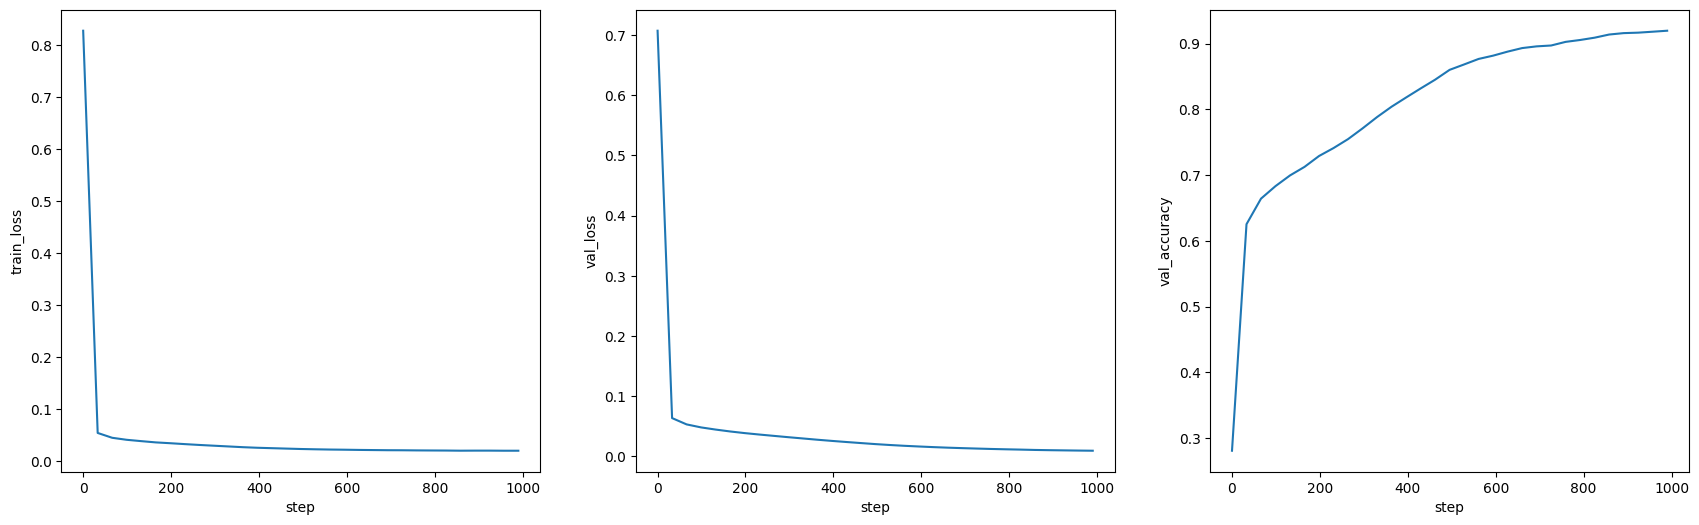

In [20]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.savefig('training_summary.png')

The R2 score is  0.4940000074738882
The R2 score with weighted variance is  0.9880000149477765


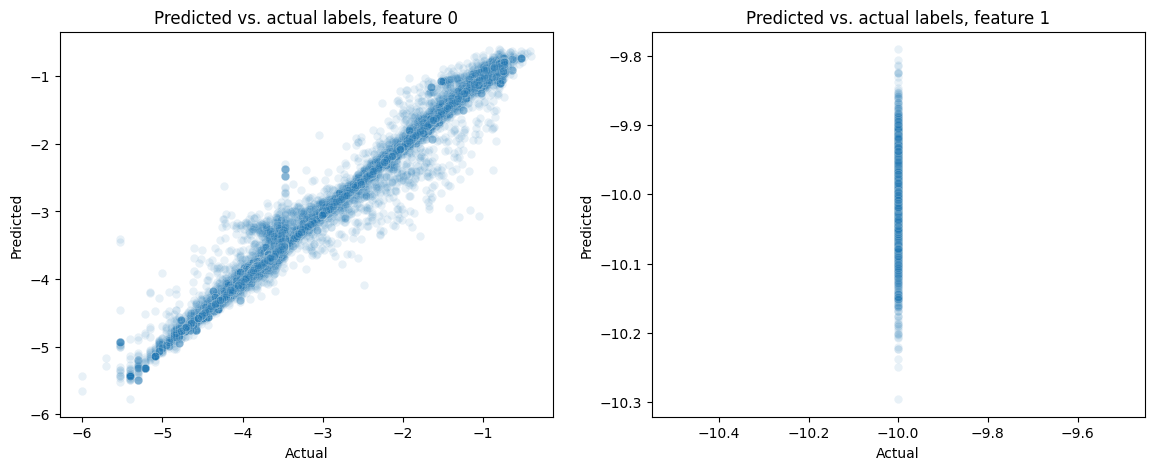

In [21]:
# params = arrayise(params)
predicted = model.apply(params, rng, x_val)
if USE_CATEGORICAL:
    predicted = jnp.argmax(predicted, axis=1)

plt.figure(figsize=(7*y_val.shape[-1], 5))
for i in range(y_val.shape[-1]):
    ax = plt.subplot(1, y_val.shape[-1], i+1)
    sns.scatterplot(x=y_val[:, i], y=predicted[:, i], alpha=0.1)
    plt.title(f'Predicted vs. actual labels, feature {i}')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')

print('The R2 score is ', r2_score(y_val, predicted))
print('The R2 score with weighted variance is ', r2_score(
    y_val, predicted, multioutput='variance_weighted'))

Text(0.5, 0.98, 'Param weights: FCN/~create_layers/linear_2')

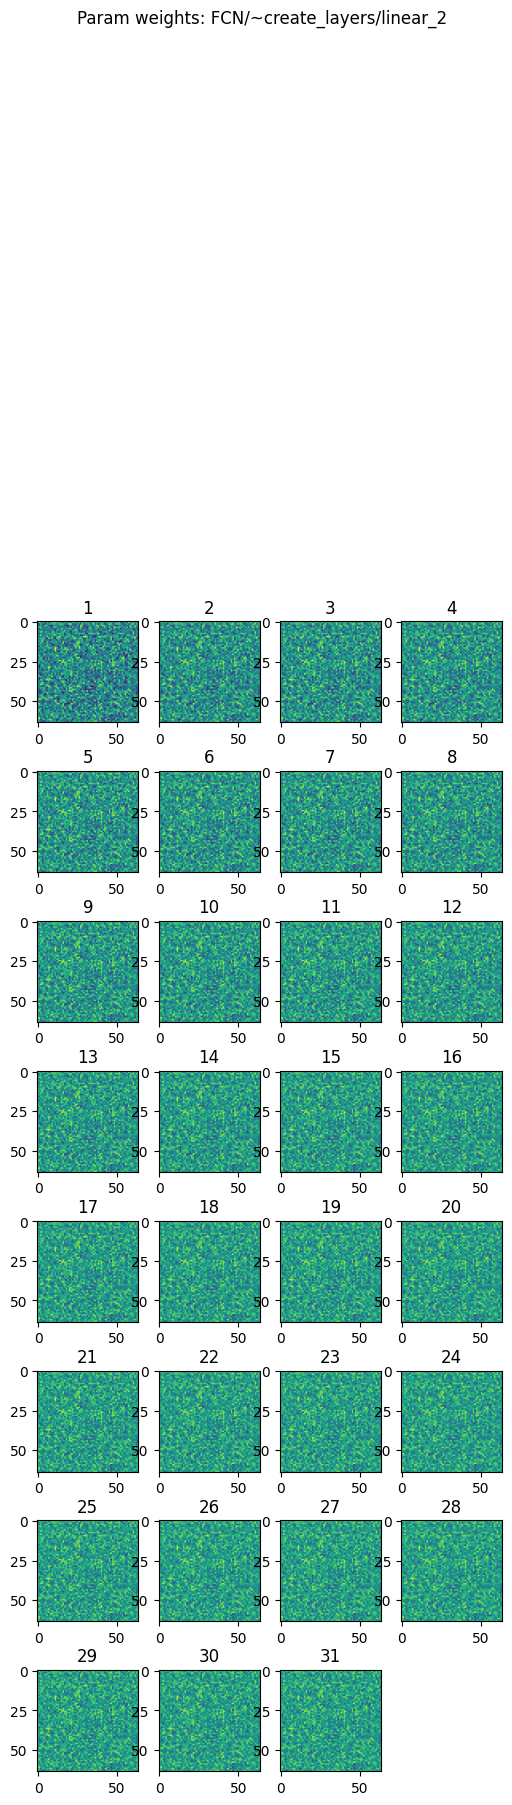

In [22]:
saves_params = [v['params'] for v in saves.values()]

plt.figure(figsize=(6*1, 10*6))
i = 1
layer_to_visualise = list(saves_params[0].keys())[2]
for s in saves_params:
    for v in [s[layer_to_visualise]]:
        ax = plt.subplot(len(saves_params), 4, i)
        plt.imshow(v['w'])
        plt.title(i)
        i += 1
plt.suptitle(f'Param weights: {layer_to_visualise}')

In [23]:
write_json(saves, out_path=save_path)

## Examine trained model


In [24]:
# saves_loaded = load_json_as_dict('saves')
# saves_loaded = load_json_as_dict('saves_20231016')
# saves_loaded = load_json_as_dict('saves_20231019')
saves_loaded = load_json_as_dict(save_path)


def arrayise(d):
    for k, v in d.items():
        if type(v) == dict:
            for kk, vv in v.items():
                d[k][kk] = jnp.array(vv)
    return d


step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

pred_y = model.apply(p, rng, x)
if USE_CATEGORICAL:
    pred_y = jnp.argmax(pred_y, axis=1)
saves_loaded.keys()

dict_keys(['0', '33', '66', '99', '132', '165', '198', '231', '264', '297', '330', '363', '396', '429', '462', '495', '528', '561', '594', '627', '660', '693', '726', '759', '792', '825', '858', '891', '924', '957', '990'])

The R2 score is  0.4938154643505285
The R2 score with weighted variance is  0.9876309287010568


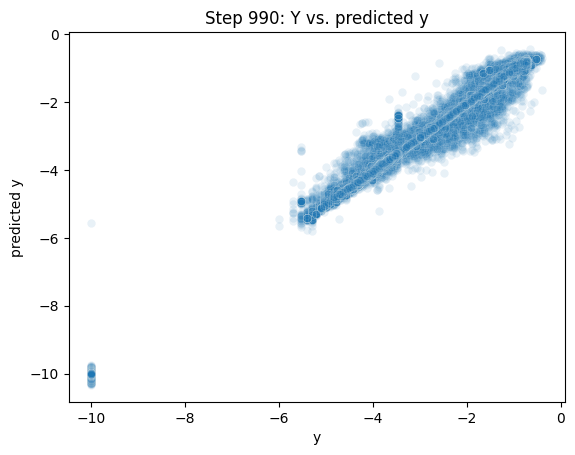

In [25]:
sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1)
plt.title(f'Step {step}: Y vs. predicted y')
plt.xlabel('y')
plt.ylabel('predicted y')

print('The R2 score is ', r2_score(y, pred_y))
print('The R2 score with weighted variance is ', r2_score(
    y, pred_y, multioutput='variance_weighted'))

In [26]:


# rows = int(np.ceil(np.sqrt(len(saves_loaded))))
# cols = int(np.ceil(np.sqrt(len(saves_loaded))))

# fig = plt.figure(figsize=(7*cols, 6*rows))
# for i, (step, v) in enumerate(saves_loaded.items()):
#     p = v['params']
#     p = arrayise(p)

#     pred_y = model.apply(p, rng, x)

#     ax = plt.subplot(rows, cols, i+1)
#     sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1)
#     plt.title(f'Step {step}: Y vs. predicted y')
#     plt.xlabel('y')
#     plt.ylabel('predicted y')

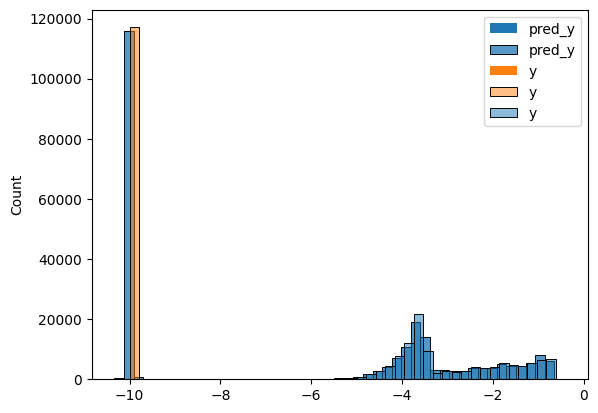

In [27]:

sns.histplot(pred_y.flatten(), label='pred_y')
sns.histplot(y, label='y')
plt.legend()

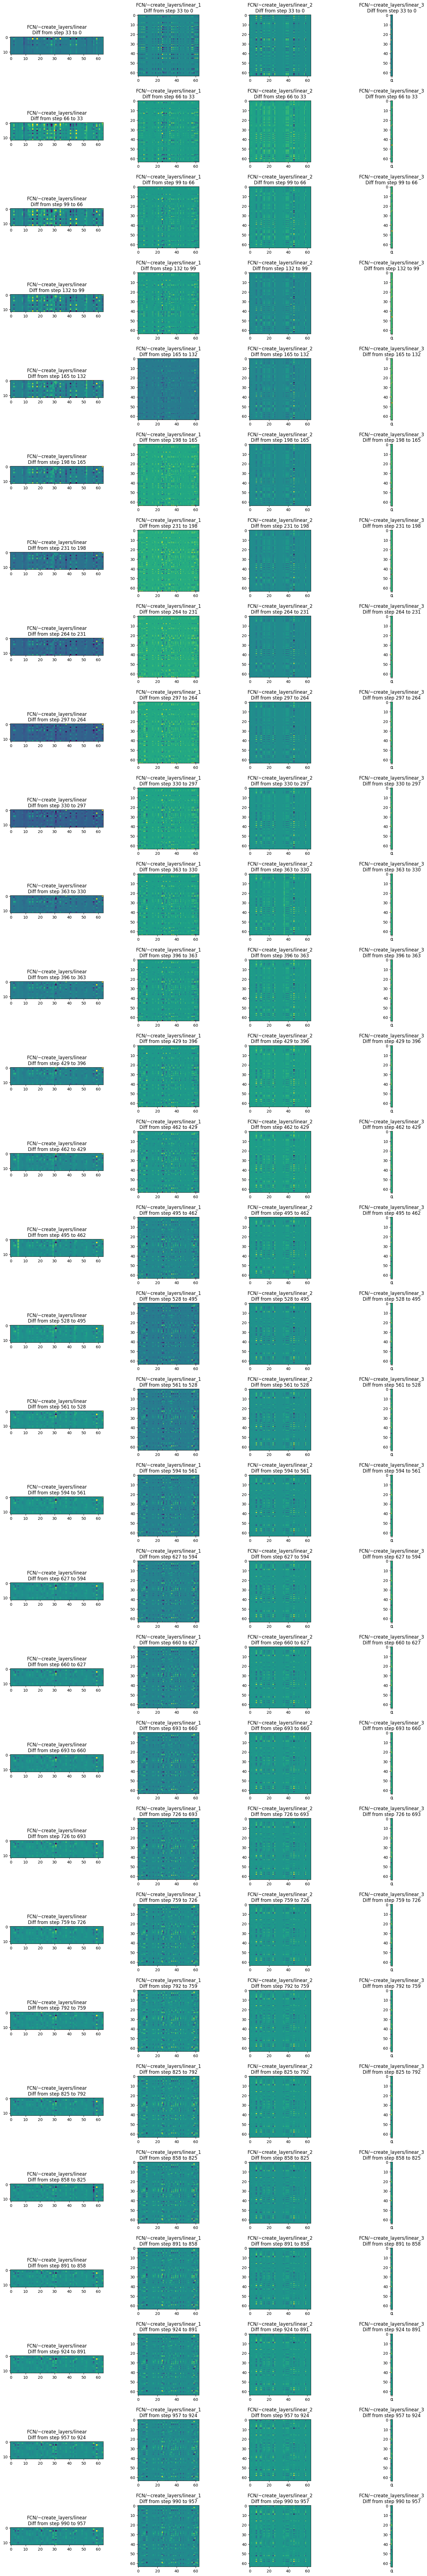

In [28]:

rows = len(saves_loaded.keys())
cols = len(p)
fig = plt.figure(figsize=(5*cols, 4*rows))
fig.subplots_adjust(hspace=0.4)
i = 0
diff_min = 0
diff_max = 0
for k0, k1 in zip(list(saves_loaded.keys())[:-1], list(saves_loaded.keys())[1:]):
    p0 = saves_loaded[k0]['params']
    p0 = arrayise(p0)
    p = saves_loaded[k1]['params']
    p = arrayise(p)

    for k, v0, v in zip(p0.keys(), p0.values(), p.values()):
        diff = v['w'] - v0['w']
        diff_min = np.min([diff_min, diff.min()])
        diff_max = np.max([diff_max, diff.max()])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(diff)
        # plt.imshow(v['w'])
        # plt.clim(diff_min, diff_max)
        i += 1
        plt.title(f'{k}\nDiff from step {k1} to {k0}')

### TSNE


In [29]:
step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

pred_y = model.apply(p, rng, x_val)

In [30]:
x_og_val = xscaler.inverse_transform(x_val)

try:
    cols = list(map(str, np.arange(x.shape[-1])))
    df1 = pd.DataFrame(data=x_og_val, columns=cols)
    # df1['image'] = df1.apply(lambda row: wandb.Image(row.values.reshape(1, x_og_val.shape[-1])), axis=1)
    if USE_CATEGORICAL:
        df1['Predicted Sensitivity'] = np.argmax(pred_y, axis=1)
    else:
        df1['Predicted Sensitivity'] = pred_y[:, 0]
        df1['Predicted Sensitivity ratio from mutation to base'] = pred_y[:, 1]
    df1['Actual Sensitivity'] = y_val[:, 0]
    df1['Actual Sensitivity ratio from mutation to base'] = y_val[:, 1]
    df1['interacting'] = [str(np.round(i, 2)) for i in list(x_og_val[:, :6])]
    df1['interacting diffs'] = [str(np.round(i, 2)) for i in list(x_og_val[:, 6:])]
    df1['zeros_idxs'] = [''.join([str(ii) for ii in np.argwhere(
        i == 0).tolist()]).replace('[', '').replace(']', '') for i in list(x_og_val[:, :6])]
    # df1['target'] = df1['target'].apply(str)
    # df1 = df1[df1.columns.tolist()[-2:] + df1.columns.tolist()[:-2]]

    wandb.log({"digits": df1})
except:
    print('nah')
wandb.finish()

nah
